# Model Training

Try out different architecture and use raytune to select best hyperparameters.

### 1. Import Packages and check versions

In [1]:
# import own scripts
import src.classifier as classifier
import src.preprocess_data as prepData
import src.hyperparameter_tuning as hyperTune
import src.visualize_data as vizData
#import src.tester as tester

In [18]:
# update own scripts
from importlib import reload
reload(classifier)
reload(prepData)
reload(hyperTune)
reload(vizData)

<module 'src.visualize_data' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_NLP\\3_assignment\\NLP-Aspect-Term-Polarity-Classification\\src\\visualize_data.py'>

In [2]:
# basic stuff
import os
import numpy as np

# data handling
import datasets
from datasets import Dataset, DatasetDict
import pandas as pd

# pre-processing
import nltk
import sentencepiece
import stanza

# modeling
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import transformers
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler

# evaluation
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# hyperparam optimization
from ray import air, tune

# visualize
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
# check versions
print(f"pytorch: {torch.__version__} / allowed: 1.13.1")
print(f"pytorch-lightning: {pl.__version__} / allowed: 1.8.1")
print(f"transformers: {transformers.__version__} / allowed: 4.22.2")
print(f"datasets: {datasets.__version__} / allowed: 2.9.0")
print(f"sentencepiece: {sentencepiece.__version__} / allowed: 0.1.97")
print(f"scikit-learn: {sklearn.__version__} / allowed: 1.2.0")
print(f"numpy: {np.__version__} / allowed: 1.23.5")
print(f"pandas: {pd.__version__} / allowed: 1.5.3")
print(f"nltk: {nltk.__version__} / allowed: 3.8.1")
print(f"stanza: {stanza.__version__} / allowed: 1.4.2")

pytorch: 1.13.1+cu117 / allowed: 1.13.1
pytorch-lightning: 1.8.1 / allowed: 1.8.1
transformers: 4.22.2 / allowed: 4.22.2
datasets: 2.9.0 / allowed: 2.9.0
sentencepiece: 0.1.97 / allowed: 0.1.97
scikit-learn: 1.2.0 / allowed: 1.2.0
numpy: 1.23.5 / allowed: 1.23.5
pandas: 1.5.3 / allowed: 1.5.3
nltk: 3.8.1 / allowed: 3.8.1
stanza: 1.4.2 / allowed: 1.4.2


In [4]:
# set matplotlib and seaborn settings for nicer plots

%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# where to save trial results to
ray_path = os.path.abspath("")+"\\ray_results\\"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

# ignore warnings that show in every raytune run
import warnings
warnings.simplefilter(action = "ignore", category = np.VisibleDeprecationWarning)

### 2. Modeling -- Hyperparameter Tuning

implemented models (select as select as plm_name):
- "bert-base-cased" (best batch size for RTX 3070 8GB --> 32)
- "roberta-base"(best batch size for RTX 3070 8GB --> 32)
- "roberta-large" (largest possible batch size for RTX 3070 8GB --> 8)

In [13]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # basic infos
    "data_path": os.path.abspath(""),
    "max_epochs": 30,
    "batch_size": 32,
    
    # data preprocessing
    "input_enrichment": "question_sentence_target",
    
    # pre-trained language model (transformer)
    "plm_name": "roberta-base",
    "plm_freeze": False,
    
    # classifier (linear layers)
    "cls_depth":          tune.grid_search([2, 3]),
    "cls_width":          384,
    "cls_activation":     "ReLU", # tune.grid_search(["ReLU", "Sigmoid", "Tanh"])
    "cls_dropout_st":     tune.grid_search([0, 0.05, 0.1]),
    "cls_dropout_hidden": tune.grid_search([0, 0.05, 0.1]),
    
    # optimizer
    "lr": tune.grid_search([2e-5, 1e-5]),
    "wd": 1e-2,
    
    # scheduler
    "lr_s": "cosine", # tune.grid_search(["constant", "linear", "cosine"])
    "warmup": 0, # number of epochs to warm up learning rate
    
    # loss function
    "criterion": "BCE",
}

In [7]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = hyperTune.run_ray_experiment(
    hyperTune.ray_trainable, config, ray_path, num_samples,
    metric_columns = ["trn_acc", "dev_acc", "training_iteration"],
    parameter_columns = ["batch_size", "cls_depth", "cls_width", "lr", "lr_s"]
)

2023-04-16 10:34:27,565	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-04-16 13:39:02,483	INFO tune.py:798 -- Total run time: 11073.60 seconds (11073.56 seconds for the tuning loop).


**evaluate a given experiment**

In [7]:
# load experiment
restored_tuner, result_grid = hyperTune.open_validate_ray_experiment("ray_results/roberta-base_second", 
                                                                     hyperTune.ray_trainable)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


Loading results from ray_results/roberta-base_second...
Done!

No errors! Number of terminated trials: 36


In [12]:
# get best score per trial (highest validation accuracy)
N = 12
best_result_df = result_grid.get_dataframe(
    filter_metric="dev_acc", filter_mode="max"
)
best_result_df = best_result_df[["trial_id", "training_iteration", "config/input_enrichment",
                                 "config/cls_depth", "config/cls_width",
                                 "config/lr",
                                 "trn_loss", "dev_loss", "trn_acc", "dev_acc"]]
best_result_df = best_result_df.sort_values(by=["dev_acc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

,trial_id,training_iteration,config/input_enrichment,config/cls_depth,config/cls_width,config/lr,trn_loss,dev_loss,trn_acc,dev_acc
34,80af7_00034,25,question_sentence_target,2,384,0.00002,0.028646,1.127769,0.991351,0.893617
32,80af7_00032,14,question_sentence_target,3,192,0.00002,0.098831,0.968316,0.969395,0.890957
26,80af7_00026,11,question_sentence,3,384,0.00002,0.092272,0.790726,0.972056,0.890957
25,80af7_00025,15,question_sentence,2,384,0.00002,0.053281,1.027427,0.982701,0.890957
0,80af7_00000,13,question_sentence,1,48,0.00005,0.039174,1.276566,0.984032,0.888298
19,80af7_00019,13,question_sentence,2,48,0.00002,0.075782,0.870199,0.978709,0.888298
3,80af7_00003,13,question_sentence,1,192,0.00005,0.039174,1.276566,0.984032,0.888298
6,80af7_00006,13,question_sentence,1,384,0.00005,0.039174,1.276566,0.984032,0.888298
29,80af7_00029,8,question_sentence_target,3,48,0.00002,0.362539,0.511895,0.932136,0.888298
20,80af7_00020,26,question_sentence,3,48,0.00002,0.103932,0.755219,0.986028,0.888298


**take best parameters and check reproducibility**

In [11]:
config = {
    # basic infos
    "data_path": os.path.abspath(""),
    "max_epochs": 10,
    "batch_size": 32,
    
    # data preprocessing
    "input_enrichment": "aspect_target_sentence",
    
    # pre-trained language model (transformer)
    # "bert-base-cased", "cardiffnlp/twitter-roberta-base-sentiment-latest", "roberta-base"
    "plm_name": "roberta-base",
    "plm_freeze": False,

    # classifier (linear layers)
    "cls_dropout_st":     0,
    "cls_channels":       [3],
    "cls_activation":     "ReLU",
    "cls_dropout_hidden": 0.2,
    
    # optimizer
    "lr": 5e-5,
    "wd": 1e-2,

    # scheduler
    "lr_s": "linear",
    "warmup": 0,
    
    # loss function
    "criterion": "BCE"
}

In [12]:
# ensure reproducibility
hyperTune.set_reproducible()

# initialise objects for training
(max_epochs, trainloader, devloader,
 model, optimizer, lr_scheduler,
 criterion, device) = hyperTune.init_training(config)

In [13]:
# perform training (no return!)
hyperTune.train_evaluate_model(max_epochs, trainloader, devloader, model,
                               optimizer, lr_scheduler, criterion, device,
                               verbose = True, ray = False, return_obj = False,
                               save_best_model = True)

Epoch [1/10] -> Trn Loss: 0.81, Dev Loss: 0.6013, Trn Acc: 0.59, Dev Acc: 0.7447
Epoch [2/10] -> Trn Loss: 0.55, Dev Loss: 0.6092, Trn Acc: 0.82, Dev Acc: 0.8484
Epoch [3/10] -> Trn Loss: 0.41, Dev Loss: 0.7306, Trn Acc: 0.86, Dev Acc: 0.8165
Epoch [4/10] -> Trn Loss: 0.24, Dev Loss: 0.7002, Trn Acc: 0.91, Dev Acc: 0.8378
Epoch [5/10] -> Trn Loss: 0.15, Dev Loss: 0.8916, Trn Acc: 0.93, Dev Acc: 0.8537
Epoch [6/10] -> Trn Loss: 0.17, Dev Loss: 0.8072, Trn Acc: 0.93, Dev Acc: 0.8564
Epoch [7/10] -> Trn Loss: 0.08, Dev Loss: 1.1019, Trn Acc: 0.97, Dev Acc: 0.8803
Epoch [8/10] -> Trn Loss: 0.05, Dev Loss: 1.1485, Trn Acc: 0.98, Dev Acc: 0.8777
Epoch [9/10] -> Trn Loss: 0.05, Dev Loss: 1.1747, Trn Acc: 0.98, Dev Acc: 0.8777
Epoch [10/10] -> Trn Loss: 0.04, Dev Loss: 1.1989, Trn Acc: 0.98, Dev Acc: 0.883


**take best model and evaluate it**

In [14]:
# get class labels
class_dict = {0: "negative", 1: "neutral", 2: "positive"}

In [15]:
# ensure reproducibility
hyperTune.set_reproducible()

# initialise objects for training
(max_epochs, trainloader, devloader,
 model, optimizer, lr_scheduler,
 criterion, device) = hyperTune.init_training(config)

In [16]:
# load best model
path = os.path.abspath("")+"\\models\\RobertaModel_finetuned.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [17]:
# evaluate best model on train set
(trn_acc,
 trn_lbls, trn_outputs,
 trn_preds) = hyperTune.evaluate(trainloader, model, device)

# validate (compare with previous print statement to make sure that it's actually the best model)
print(f"Train Acc: {round(trn_acc, 4)}")

Train Acc: 0.986


In [18]:
# evaluate best model on dev set
(dev_acc,
 dev_lbls, dev_outputs,
 dev_preds) = hyperTune.evaluate(devloader, model, device)

# validate (compare with previous print statement to make sure that it's actually the best model)
print(f"Dev Acc: {round(dev_acc, 4)}")

Dev Acc: 0.883


Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       390
         1.0       0.87      1.00      0.93        58
         2.0       1.00      0.98      0.99      1055

    accuracy                           0.99      1503
   macro avg       0.95      0.99      0.97      1503
weighted avg       0.99      0.99      0.99      1503



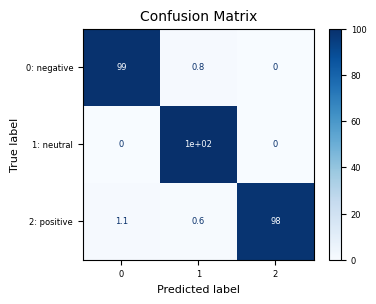



Dev performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82        98
         1.0       0.43      0.43      0.43        14
         2.0       0.93      0.93      0.93       264

    accuracy                           0.88       376
   macro avg       0.73      0.73      0.73       376
weighted avg       0.88      0.88      0.88       376



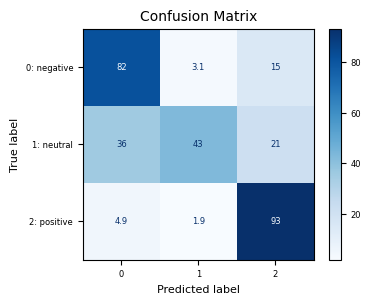

In [19]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(trn_lbls, trn_preds, zero_division = 0))

vizData.get_confusion_matrix(trn_lbls, trn_preds, class_dict)

print('\n\nDev performance')
print('-------------------------------------------------------')
print(classification_report(dev_lbls, dev_preds,  zero_division = 0))

vizData.get_confusion_matrix(dev_lbls, dev_preds, class_dict)

**model architecture**

In [17]:
import torchinfo

In [18]:
device = torch.device('cpu')
model.to(device)
print("done")

done


In [19]:
torchinfo.summary(model, input_size = (2, 16, 50), dtypes=['torch.IntTensor'], device = device)

Layer (type:depth-idx)                                  Output Shape              Param #
TransformerSentimentClassifier                          [16, 3]                   --
├─BertModel: 1-1                                        [16, 768]                 --
│    └─BertEmbeddings: 2-1                              [16, 50, 768]             --
│    │    └─Embedding: 3-1                              [16, 50, 768]             22,268,928
│    │    └─Embedding: 3-2                              [16, 50, 768]             1,536
│    │    └─Embedding: 3-3                              [1, 50, 768]              393,216
│    │    └─LayerNorm: 3-4                              [16, 50, 768]             1,536
│    │    └─Dropout: 3-5                                [16, 50, 768]             --
│    └─BertEncoder: 2-2                                 [16, 50, 768]             --
│    │    └─ModuleList: 3-6                             --                        85,054,464
│    └─BertPooler: 2-3           